In [ ]:
import tensorflow as tf
import glob

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

# Preprocessing Data Organization Steps 

# U- Net Model Defintion

In [ ]:
OUTPUT_CHANNELS = 4 #four different classes technically, but one of the classes can be pixel value black 

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)
  last = tf.keras.layers.Reshape((128*128, 4), input_shape=(128,128,4))
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# Model Training

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Visualize the Model

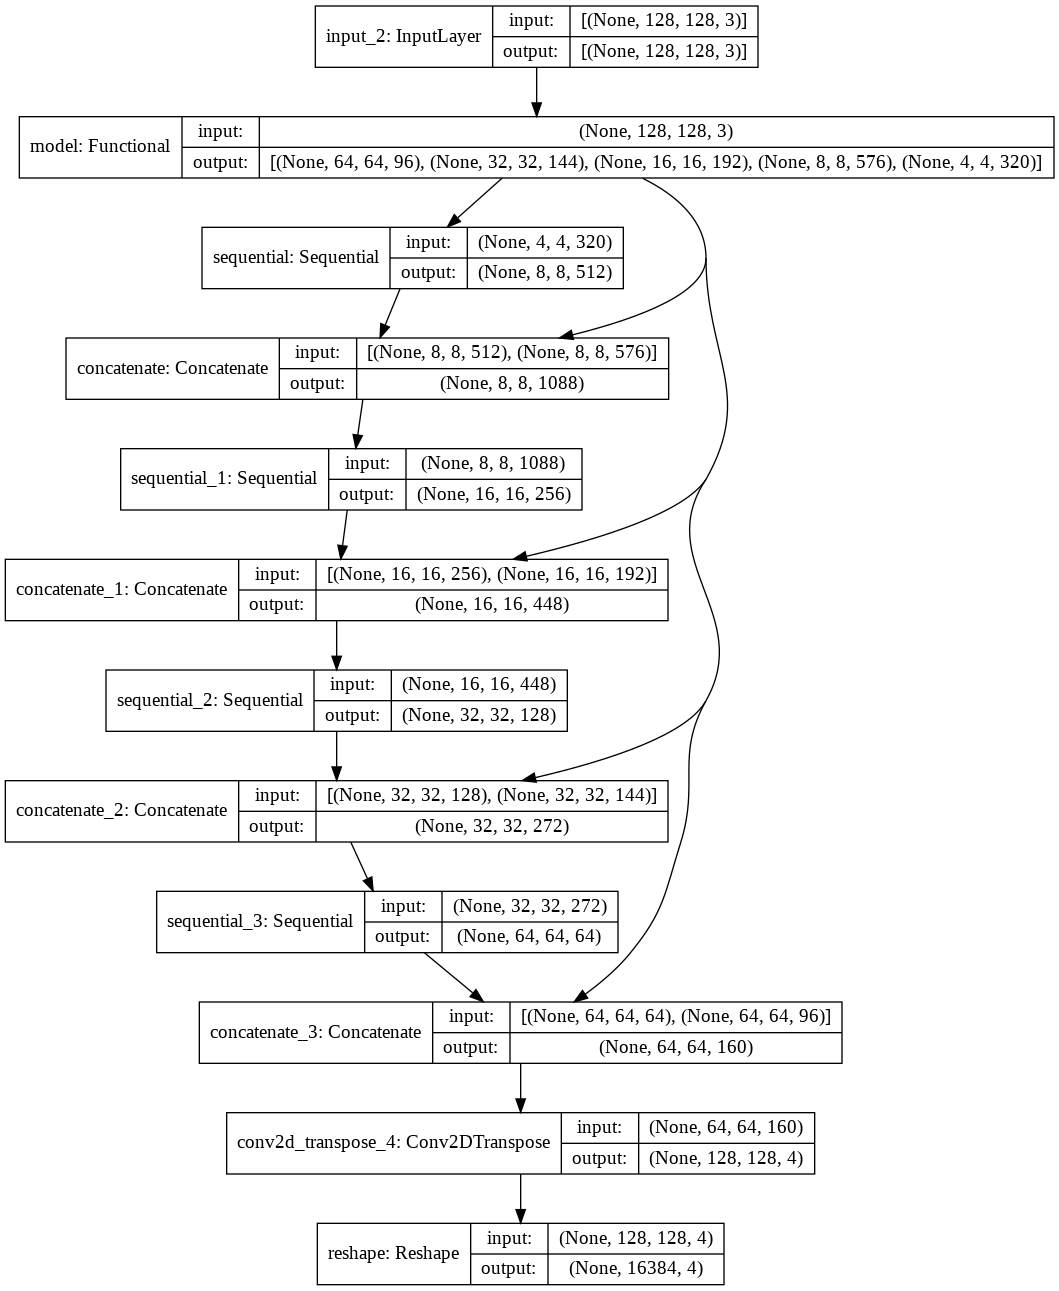

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Load Training Data

In [ ]:
#validation training data for examples
Xtrain = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/XtrainDataResized/Xdata_1_resized.npy')
Ytrain = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/YtrainDataResized/Ylabels_1_resized.npy')
Xtrain_val = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/XtestDataResized/Xdata_9_resized.npy')
Ytrain_val = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/YtestDataResized/Ylabels_9_resized.npy')

### Display Training Results as Updated and Show a Few Example Images Before Training

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow((display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
def create_mask(pred_mask):

  pred_mask = np.reshape(pred_mask, (128,128,4))
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

In [ ]:
def show_predictions(X,Y, num=0):

  x = X[num,:,:,:]
  pred_mask = model.predict(x[tf.newaxis,...])
  pred_mask = create_mask(pred_mask)
  display([X[num,:,:,:], Y[num,:,:,0], pred_mask[:,:,0]])

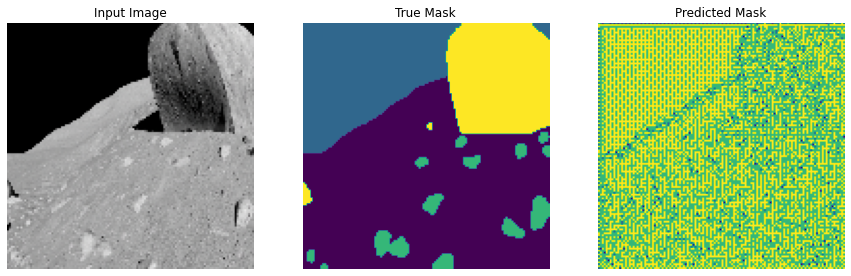

In [ ]:
show_predictions(Xtrain_val, Ytrain_val,22)

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions(Xtrain_val, Ytrain_val,22)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

## Model Fitting

# Set Up Training and Validation Parameters

In [ ]:
#load data 
FileDirX= '/content/drive/MyDrive/CS 738/Project/Batched Data/XtrainDataResized/*.npy'
FileDirY= '/content/drive/MyDrive/CS 738/Project/Batched Data/YtrainDataResized/*.npy'

Files_ListX = glob.glob(FileDirX)
Files_ListY = glob.glob(FileDirY)

Files_ListX.sort()
Files_ListY.sort()

In [ ]:
#initialize class weights using sample weights method calculated during the pre-processing
cl_weights = {}
cl_weights[0]=.3290
cl_weights[1] = 1.283
cl_weights[2] =10.337
cl_weights[3] = 11.774

Xtrain_val = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/XtestDataResized/Xdata_9_resized.npy')
Ytrain_val = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/YtestDataResized/Ylabels_9_resized.npy')


#reformat the validation data to fit with the model architecture
Ytrain_valNew = np.zeros((Ytrain_val.shape[0], 128*128,1))
for k in range(0,Ytrain.shape[0]):
  imLabels = Ytrain_val[k,:,:,:] # load the label for the training image
  imLabels = imLabels.reshape((128*128))
  Ytrain_valNew[k,:] = imLabels.reshape((128*128,1))


#load all the training data
for k in range(0,len(Files_ListX)):
  if (k==1):
    Xtrain = np.load(Files_ListX[k])#'/content/drive/MyDrive/CS 738/Project/Batched Data/XtrainDataResized/Xdata_3_resized.npy') 
    Ytrain = np.load(Files_ListY[k]) #'/content/drive/MyDrive/CS 738/Project/Batched Data/YtrainDataResized/Ylabels_3_resized.npy')
  else:
    dataX = np.load(Files_ListX[k])
    dataY = np.load(Files_ListY[k])
    Xtrain = np.concatenate((Xtrain, dataX), axis=0) # create large training set
    Ytrain = np.concatenate((Ytrain, dataY), axis=0)
  
#get the sample weights to avoid overfitting on background/sky
sample_weights = np.zeros((Xtrain.shape[0],128*128))
YtrainNew = np.zeros((Ytrain.shape[0], 128*128,1)) # reshape Y train to fit model architecture

for k in range(0,Ytrain.shape[0]): # build proper sample weights
  imLabels = Ytrain[k,:,:,:] # load the label for the training image
  imLabels = imLabels.reshape((128*128))
  UpdateIndices = np.where(imLabels == 0)
  sample_weights[k,UpdateIndices] = cl_weights[0]
  UpdateIndices = np.where(imLabels == 1)
  sample_weights[k,UpdateIndices] = cl_weights[1]
  UpdateIndices = np.where(imLabels == 2)
  sample_weights[k,UpdateIndices] = cl_weights[2]
  UpdateIndices = np.where(imLabels == 3)
  sample_weights[k,UpdateIndices] = cl_weights[3]
  YtrainNew[k,:] = imLabels.reshape((128*128,1))


In [ ]:
TRAIN_LENGTH = Xtrain.shape[0]
VAL_LENGTH = Xtrain_val.shape[0]
BATCH_SIZE = 64
#BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = VAL_LENGTH//BATCH_SIZE//VAL_SUBSPLITS
VALIDATION_BATCH_SIZE = Xtrain_val.shape[0]

Epoch 1/20
110/110 [==============================] - 635s 6s/step - loss: 0.8484 - accuracy: 0.6526 - val_loss: 0.3193 - val_accuracy: 0.9098


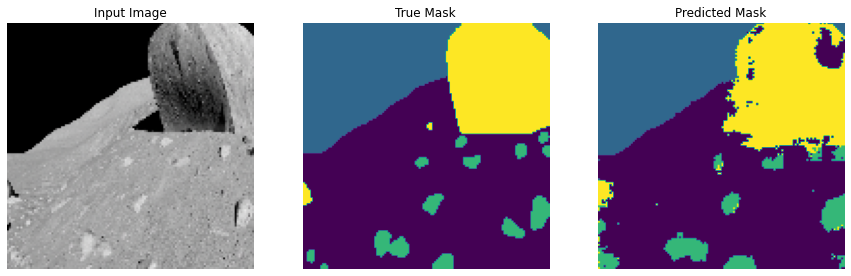


Sample Prediction after epoch 1

Epoch 2/20
110/110 [==============================] - 632s 6s/step - loss: 0.4030 - accuracy: 0.8420 - val_loss: 0.4160 - val_accuracy: 0.8561


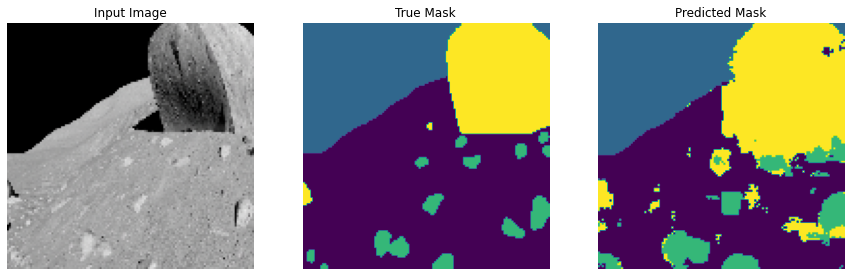


Sample Prediction after epoch 2

Epoch 3/20
110/110 [==============================] - 629s 6s/step - loss: 0.3773 - accuracy: 0.8515 - val_loss: 0.4316 - val_accuracy: 0.8485


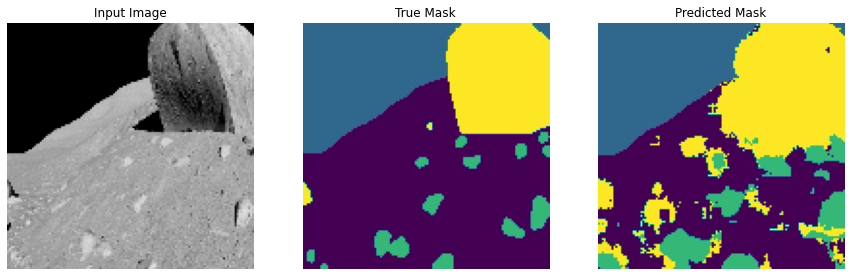


Sample Prediction after epoch 3

Epoch 4/20
110/110 [==============================] - 624s 6s/step - loss: 0.3542 - accuracy: 0.8540 - val_loss: 0.4175 - val_accuracy: 0.8471


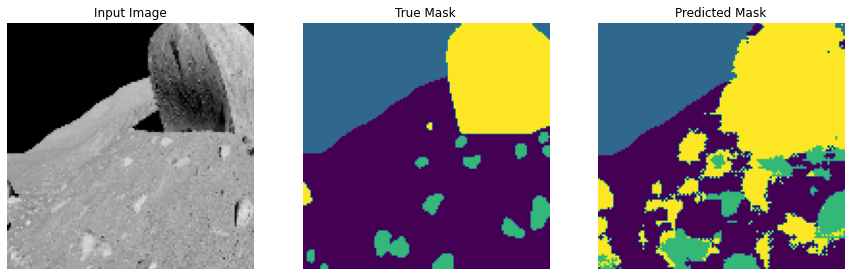


Sample Prediction after epoch 4

Epoch 5/20
110/110 [==============================] - 626s 6s/step - loss: 0.3518 - accuracy: 0.8587 - val_loss: 0.3819 - val_accuracy: 0.8636


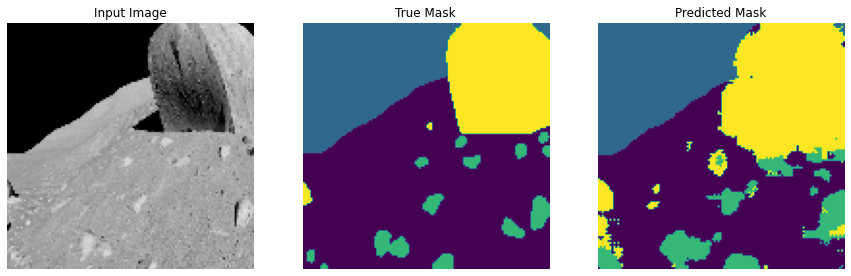


Sample Prediction after epoch 5

Epoch 6/20
110/110 [==============================] - 626s 6s/step - loss: 0.3370 - accuracy: 0.8609 - val_loss: 0.3597 - val_accuracy: 0.8733


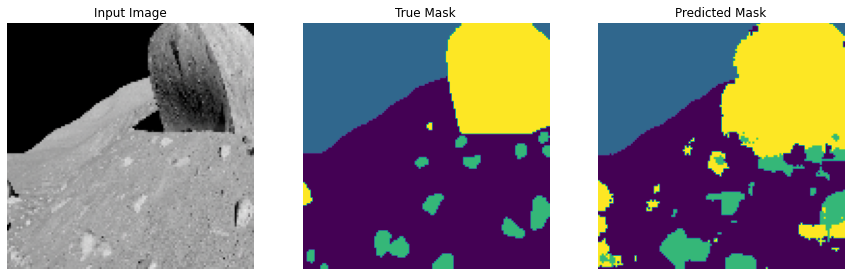


Sample Prediction after epoch 6

Epoch 7/20
110/110 [==============================] - 628s 6s/step - loss: 0.3410 - accuracy: 0.8612 - val_loss: 0.4508 - val_accuracy: 0.8314


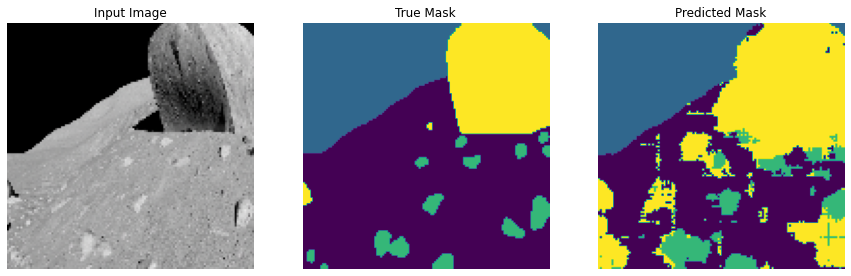


Sample Prediction after epoch 7

Epoch 8/20
110/110 [==============================] - 628s 6s/step - loss: 0.3198 - accuracy: 0.8672 - val_loss: 0.3864 - val_accuracy: 0.8641


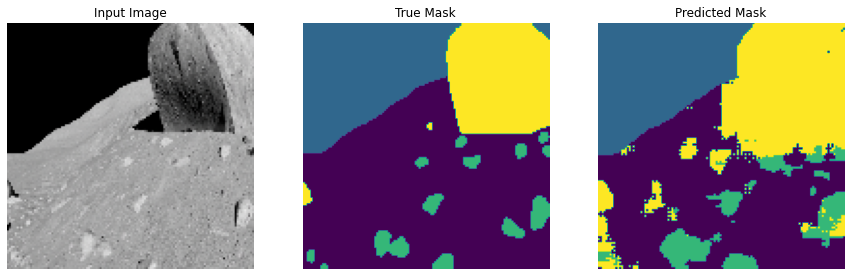


Sample Prediction after epoch 8

Epoch 9/20
110/110 [==============================] - 627s 6s/step - loss: 0.3238 - accuracy: 0.8618 - val_loss: 0.3234 - val_accuracy: 0.8844


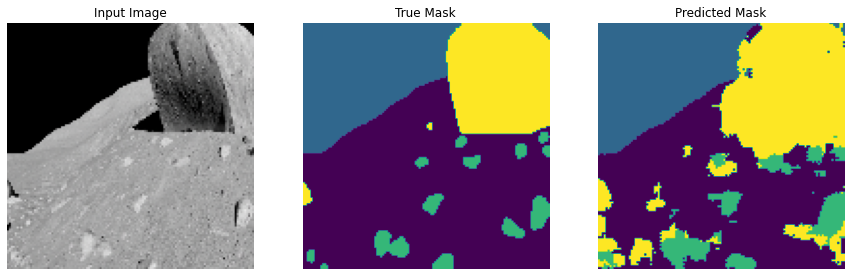


Sample Prediction after epoch 9

Epoch 10/20
110/110 [==============================] - 626s 6s/step - loss: 0.3128 - accuracy: 0.8705 - val_loss: 0.3714 - val_accuracy: 0.8647


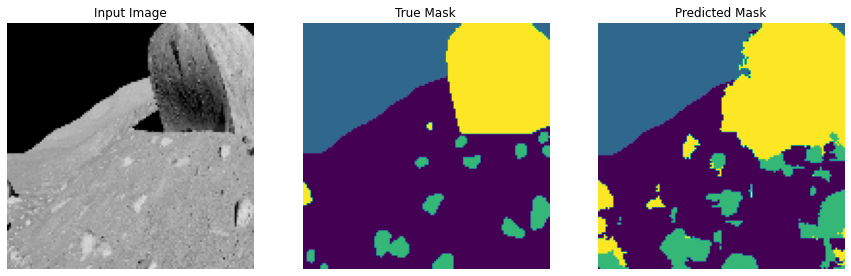


Sample Prediction after epoch 10

Epoch 11/20
110/110 [==============================] - 628s 6s/step - loss: 0.2994 - accuracy: 0.8724 - val_loss: 0.3378 - val_accuracy: 0.8780


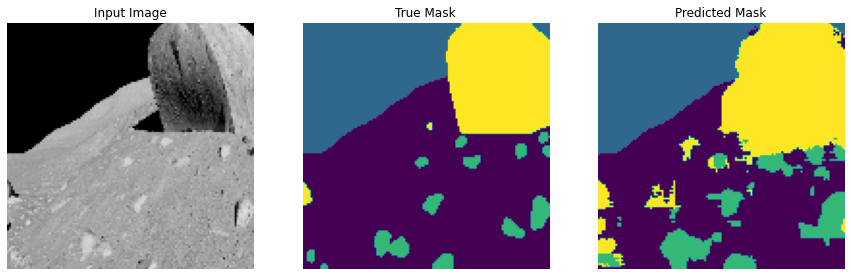


Sample Prediction after epoch 11

Epoch 12/20
110/110 [==============================] - 628s 6s/step - loss: 0.2937 - accuracy: 0.8715 - val_loss: 0.4367 - val_accuracy: 0.8385


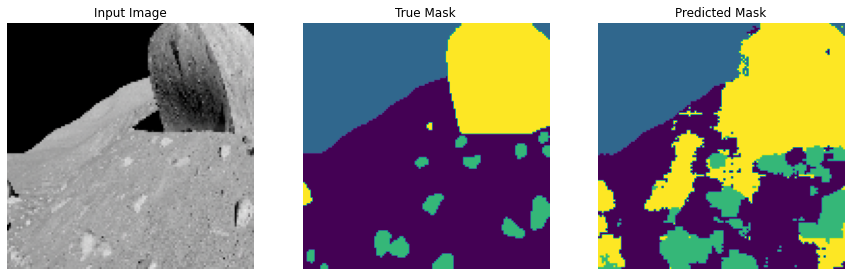


Sample Prediction after epoch 12

Epoch 13/20
110/110 [==============================] - 630s 6s/step - loss: 0.2837 - accuracy: 0.8747 - val_loss: 0.3365 - val_accuracy: 0.8783


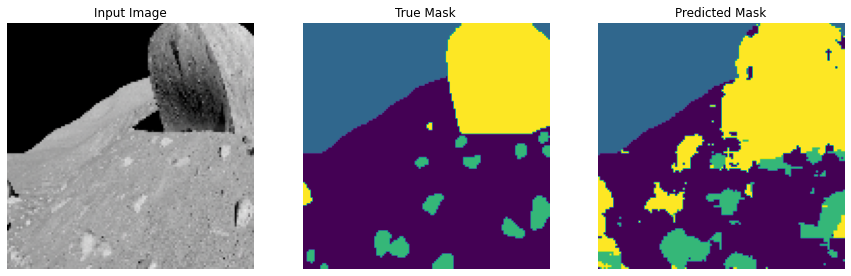


Sample Prediction after epoch 13

Epoch 14/20
110/110 [==============================] - 631s 6s/step - loss: 0.2650 - accuracy: 0.8788 - val_loss: 0.4149 - val_accuracy: 0.8551


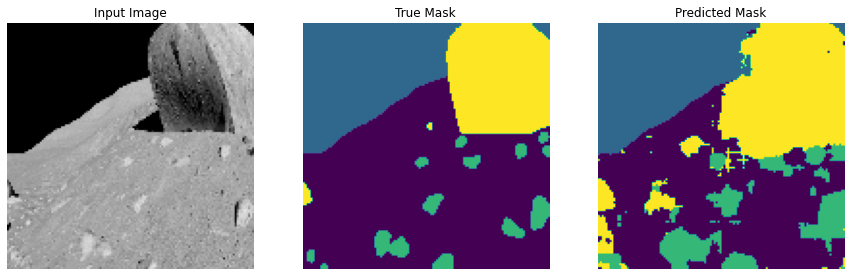


Sample Prediction after epoch 14

Epoch 15/20
110/110 [==============================] - 629s 6s/step - loss: 0.2702 - accuracy: 0.8745 - val_loss: 0.3224 - val_accuracy: 0.8832


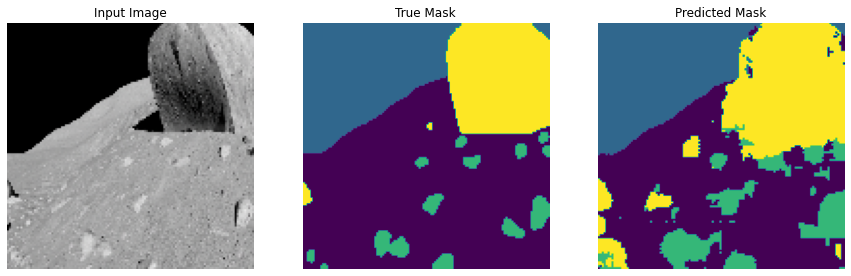


Sample Prediction after epoch 15

Epoch 16/20
110/110 [==============================] - 630s 6s/step - loss: 0.2502 - accuracy: 0.8833 - val_loss: 0.3159 - val_accuracy: 0.8882


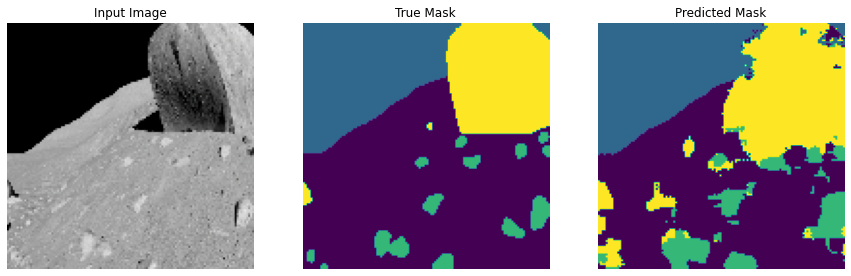


Sample Prediction after epoch 16

Epoch 17/20
110/110 [==============================] - 632s 6s/step - loss: 0.2507 - accuracy: 0.8856 - val_loss: 0.3424 - val_accuracy: 0.8734


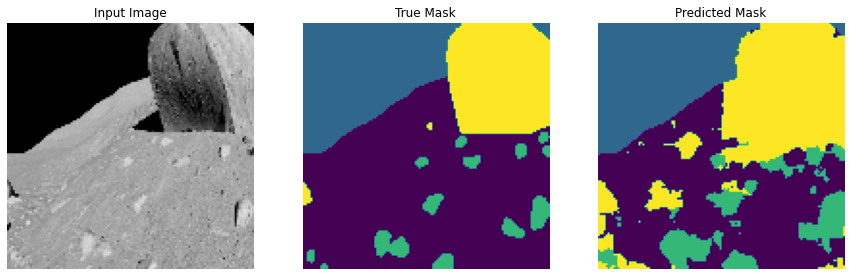


Sample Prediction after epoch 17

Epoch 18/20
110/110 [==============================] - 631s 6s/step - loss: 0.2396 - accuracy: 0.8837 - val_loss: 0.3497 - val_accuracy: 0.8725


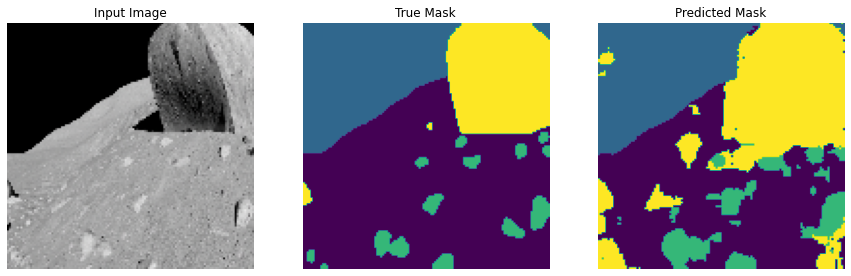


Sample Prediction after epoch 18

Epoch 19/20
110/110 [==============================] - 634s 6s/step - loss: 0.2243 - accuracy: 0.8894 - val_loss: 0.3409 - val_accuracy: 0.8729


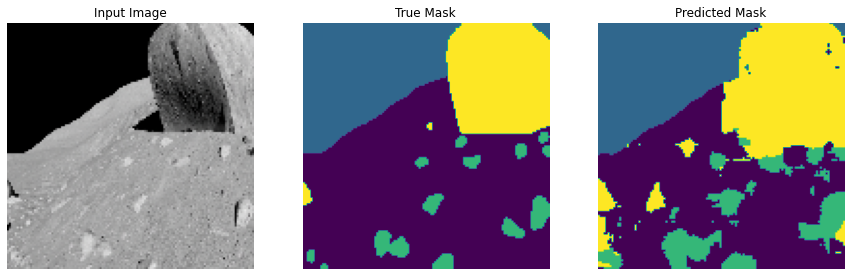


Sample Prediction after epoch 19

Epoch 20/20
110/110 [==============================] - 628s 6s/step - loss: 0.2165 - accuracy: 0.8898 - val_loss: 0.3420 - val_accuracy: 0.8714


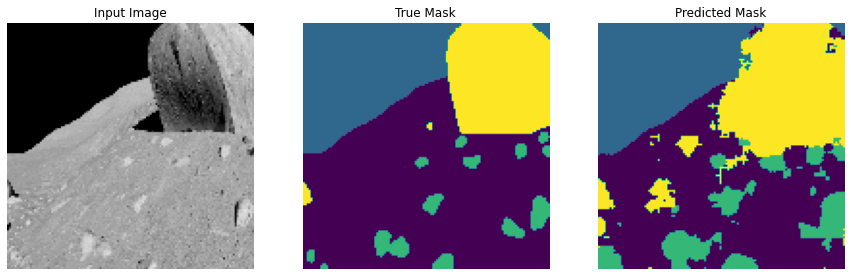


Sample Prediction after epoch 20



In [ ]:
#train on new batch
model_history = model.fit(x=Xtrain,y=YtrainNew, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_batch_size=VALIDATION_BATCH_SIZE,
                          validation_data= tuple((Xtrain_val, Ytrain_valNew)),
                          sample_weight = sample_weights,
                          shuffle = True,
                          callbacks=[DisplayCallback()])
  

## Plot Validation Curve

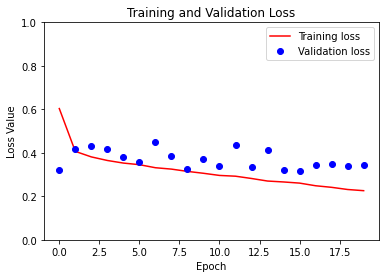

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
whos

Variable                Type          Data/Info
-----------------------------------------------
BATCH_SIZE              int           64
DisplayCallback         type          <class '__main__.DisplayCallback'>
EPOCHS                  int           20
FileDirX                str           /content/drive/MyDrive/CS<...>a/XtrainDataResized/*.npy
FileDirY                str           /content/drive/MyDrive/CS<...>a/YtrainDataResized/*.npy
Files_ListX             list          n=9
Files_ListY             list          n=9
OUTPUT_CHANNELS         int           4
STEPS_PER_EPOCH         int           110
TRAIN_LENGTH            int           7103
UpdateIndices           tuple         n=1
VALIDATION_BATCH_SIZE   int           888
VALIDATION_STEPS        int           2
VAL_LENGTH              int           888
VAL_SUBSPLITS           int           5
Xtrain                  ndarray       7103x128x128x3: 349126656 elems, type `float32`, 1396506624 bytes (1331.8125 Mb)
Xtrain_val              nda